## Introduction

In this project, we design and implement a real-time payment data pipeline for Darooghe, a payment service provider facilitating transactions through an online gateway, POS devices, mobile applications, and NFC (contactless) payments. The primary objectives are to ingest transaction events at scale, validate and process them in real time, detect and flag fraudulent activity, compute commission metrics, and store both raw and aggregated data for historical analysis and visualization. This architecture ensures high-throughput, low-latency handling of payment events, enabling Darooghe to monitor transaction flows and business insights continuously

### Apache Kafka
Apache Kafka is an open-source distributed event streaming platform used here as the ingestion layer. It provides a durable, fault-tolerant backbone for capturing high volumes of transaction events from a synthetic transaction generator. Transactions are published to Kafka topics (darooghe.transactions), where they can be consumed by downstream systems. Kafka’s scalability and partitioning model ensure that our pipeline can handle spikes in transaction rates with minimal latency

<div style="text-align: center;">
    <img src="additional_files\image1.png" alt="Roulette Wheel" style="width: 50%;">
</div>

### Apache Spark
Apache Spark is a unified analytics engine for large-scale data processing. In this project, we employ both Spark Streaming for real-time (micro-batch) processing of incoming Kafka events and PySpark for batch analytics on stored data. Spark Streaming reads from Kafka, performs windowed aggregations, applies fraud-detection rules, and calculates commission metrics on the fly. PySpark batch jobs analyze historical transaction data to generate reports on commission efficiency, temporal patterns, and customer segmentation


<div style="text-align: center;">
    <img src="additional_files\Picture5-2.png" alt="Roulette Wheel" style="width: 50%;">
</div>

### MongoDB
MongoDB is a NoSQL, document-oriented database chosen for its flexible schema and horizontal scalability. We use MongoDB to store validated transactions and aggregated insights. A partitioning strategy (e.g., by date or merchant) is employed to optimize query performance and data retention policies. Aggregated collections (daily, weekly, monthly summaries) support efficient historical analysis and dashboard visualizations without the overhead of re-processing raw event streams

## Import Required Libraries

In [3]:
import json
import logging
import time
import math
import shutil
import signal
import sys
from datetime import datetime, timedelta
from collections import Counter, defaultdict, deque
import pandas as pd
import matplotlib.pyplot as plt
from confluent_kafka import Consumer, Producer, KafkaException
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, udf, sum as _sum, avg, count, window, to_json, struct, lit, collect_list, to_timestamp, from_json, date_format, when, hour, stddev, expr
)
from pyspark.sql.types import DoubleType, StringType, StructType, StructField
from pymongo import MongoClient
from prometheus_client import Gauge, start_http_server
from functools import reduce


## Environment Setup

To initialize the local Kafka-based ingestion pipeline and monitoring UI, follow these steps:

1. **Start ZooKeeper**  

   Navigate to your Kafka installation directory and run:  

   ```bash
   bin/zookeeper-server-start.sh config/zookeeper.properties
   ```

2. **Start Kafka Broker**  

   In a new terminal (still inside the Kafka directory), launch the broker:  
   
   ```bash
   bin/kafka-server-start.sh config/server.properties
   ```

3. **Launch Kafdrop Monitoring UI**  

   Open a separate terminal, navigate to your Kafdrop installation folder, and execute:  
   
   ```bash
   java -jar kafdrop-4.1.0.jar --kafka.brokerConnect=localhost:9092
   ```

4. **Access the UI**  

   Open your browser and go to  

   ```
   http://localhost:9000
   ```  
   Here you can explore all Kafka topics, view partitions, offsets, and inspect individual messages.

5. **Run the Transaction Generator**  

   Finally, execute your Python producer script to start generating synthetic transactions: 

   ```bash
   python darooghe_pulse.py
   
   ```  
   As messages are produced to the `darooghe.transactions` topic, you’ll see them appear in real time within the Kafdrop UI—complete with headers, payloads, and partition metadata.

   <div style="text-align: center;">
      <img src="additional_files\Screenshot from 2025-04-26 14-11-41.png" alt="Roulette Wheel" style="width: 70%;">
   </div>

## Data Ingestion Layer

### Kafka Consumer Implementation

In [2]:
def validate_transaction(event):
    errors = []
    total_expected = event['amount'] + event['vat_amount'] + event['commission_amount']
    if event['total_amount'] != total_expected:
        errors.append('ERR_AMOUNT')


    now = datetime.datetime.utcnow()
    ts = datetime.datetime.fromisoformat(event['timestamp'].replace("Z", ""))
    day_per_sec = 86400
    if ts > now or (now - ts).total_seconds() > day_per_sec:
        errors.append('ERR_TIME')


    if event['payment_method'] == 'mobile':
        os = event.get('device_info', {}).get('os', None)
        if os not in ['Android', 'iOS']:
            errors.append('ERR_DEVICE')

    return errors

In [5]:
logging.basicConfig(level=logging.INFO)

consumer_conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'darooghe-consumer',
    'auto.offset.reset': 'earliest',
}
consumer = Consumer(consumer_conf)
consumer.subscribe(['darooghe.transactions'])

producer = Producer({'bootstrap.servers': 'localhost:9092'})

try:
    while True:
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            logging.error(f"Consumer error: {msg.error()}")
            continue

        try:
            event = json.loads(msg.value().decode('utf-8'))
            # raw_event = json.loads(msg.value().decode('utf-8'))
            # event = parse_transaction(raw_event)
            transaction_id = event.get('transaction_id', 'unknown')

            errors = validate_transaction(event)

            if errors:
                error_msg = {
                    'transaction_id': transaction_id,
                    'errors': errors,
                    'original_data': event
                }
                producer.produce(
                    'darooghe.error_logs',
                    key=transaction_id,
                    value=json.dumps(error_msg, default=str)
                )
                logging.warning(f"Invalid transaction: {transaction_id}, errors: {errors}")
            else:
                logging.info(f"Valid transaction: {transaction_id}")

        except Exception as e:
            logging.error(f"Parse error: {e}")

        producer.poll(0)

except KeyboardInterrupt:
    logging.info("Shutting down...")

finally:
    consumer.close()
    producer.flush()

INFO:root:Shutting down...


In [3]:
consumer_conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'darooghe-consumer',
    'auto.offset.reset': 'earliest',
}
consumer = Consumer(consumer_conf)
consumer.subscribe(['darooghe.transactions'])

try:
    msg = consumer.poll(timeout=10.0)
    if msg is None:
        print("No message received.")
    elif msg.error():
        print(f"Error: {msg.error()}")
    else:
        event = json.loads(msg.value().decode('utf-8'))
        # raw_event = json.loads(msg.value().decode('utf-8'))
        # event = parse_transaction(raw_event)
        print("Received message:")
        print(json.dumps(event, indent=2))

        errors = validate_transaction(event)
        if errors:
            print("Validation Errors:", errors)
        else:
            print("Message is VALID!")

finally:
    consumer.close()


Received message:
{
  "transaction_id": "d6535bd6-4ca0-47fc-a4ae-e1e3b0ff0ae4",
  "timestamp": "2025-04-25T09:14:29.271233Z",
  "customer_id": "cust_193",
  "merchant_id": "merch_41",
  "merchant_category": "entertainment",
  "payment_method": "pos",
  "amount": 1829607,
  "location": {
    "lat": 35.68359087715182,
    "lng": 51.367628166890725
  },
  "device_info": {},
  "status": "approved",
  "commission_type": "progressive",
  "commission_amount": 36592,
  "vat_amount": 164664,
  "total_amount": 2030863,
  "customer_type": "individual",
  "risk_level": 3,
  "failure_reason": null
}
Validation Errors: ['ERR_TIME']


### Schema Management

This helper function takes a raw JSON-like event (raw_event) from Kafka and:

- **Extracts** each expected field (IDs, categories, status, etc.).

- **Parses** the ISO-formatted timestamp (stripping the trailing “Z” and re-serializing to ISO).

- **Casts** numeric values (amounts, VAT, risk level) to int and coordinates to float.

- **Preserves** optional fields (device_info, failure_reason) with sensible defaults.

- **Returns** a normalized dict with all fields in the right Python types.

- **Handles** missing or malformed data by catching KeyError, ValueError, or TypeError, logging a schema error, and returning None so invalid events can be skipped or re-published to an error topic.

In [4]:
def parse_transaction(raw_event):
    try:
        event = {}
        event['transaction_id'] = str(raw_event['transaction_id'])
        event['timestamp'] = datetime.datetime.fromisoformat(
            raw_event['timestamp'].replace('Z', '')
        ).isoformat()
        event['customer_id'] = str(raw_event['customer_id'])
        event['merchant_id'] = str(raw_event['merchant_id'])
        event['merchant_category'] = str(raw_event['merchant_category'])
        event['payment_method'] = str(raw_event['payment_method'])
        event['amount'] = int(raw_event['amount'])
        event['location'] = {
            'lat': float(raw_event['location']['lat']),
            'lng': float(raw_event['location']['lng']),
        }
        event['device_info'] = raw_event.get('device_info', {})
        event['status'] = str(raw_event['status'])
        event['commission_type'] = str(raw_event['commission_type'])
        event['commission_amount'] = int(raw_event['commission_amount'])
        event['vat_amount'] = int(raw_event['vat_amount'])
        event['total_amount'] = int(raw_event['total_amount'])
        event['customer_type'] = str(raw_event['customer_type'])
        event['risk_level'] = int(raw_event['risk_level'])
        event['failure_reason'] = raw_event.get('failure_reason', None)
        return event
    except (KeyError, ValueError, TypeError) as e:
        print(f"Schema error: {e}")
        return None


## Batch Processing Layer

### Collect data from Kafka (once) and save to a local file (e.g., JSON)

In [5]:
consumer = Consumer({
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'batch-job-consumer',
    'auto.offset.reset': 'earliest',
})
consumer.subscribe(['darooghe.transactions'])

with open('transactions_data.json', 'w') as f:
    for _ in range(10000):
        msg = consumer.poll(1.0)
        if msg is None or msg.error():
            continue
        raw_event = msg.value().decode('utf-8')
        f.write(raw_event + '\n')

consumer.close()

### Use PySpark to analyze that saved file

The computed metrics are defined by the following formulas:

- **Total Commission** per category:  
  $$ \text{total\_commission} = \sum_{i=1}^{N} \text{commission\_amount}_i $$

- **Average Commission** per transaction:  
  $$ \text{avg\_commission} = \frac{1}{N} \sum_{i=1}^{N} \text{commission\_amount}_i $$

- **Transaction Count**:  
  $$ \text{transaction\_count} = N $$

- **Average Commission Ratio**:  
  $$ \text{avg\_commission\_ratio} = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{commission\_amount}_i}{\text{total\_amount}_i} $$


In [6]:
from pyspark.sql import SparkSession


spark = SparkSession.getActiveSession()

if spark is not None:
    spark.stop()     

spark = SparkSession.builder \
    .appName("CommissionAnalysisBatchJob") \
    .getOrCreate()

transactions_df = spark.read.json("transactions_data.json")

aggregated_metrics = transactions_df.groupBy("merchant_category").agg(
    _sum("commission_amount").alias("total_commission"),
    avg("commission_amount").alias("avg_commission"),
    count("*").alias("transaction_count"),
    avg(col("commission_amount") / col("total_amount")).alias("avg_commission_ratio")
)

aggregated_metrics.show(truncate=False)


spark.stop()

25/04/28 19:33:29 WARN Utils: Your hostname, amir-Lenovo resolves to a loopback address: 127.0.1.1; using 192.168.170.64 instead (on interface wlp8s0)
25/04/28 19:33:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 19:33:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/28 19:33:45 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------------+----------------+------------------+-----------------+--------------------+
|merchant_category|total_commission|avg_commission    |transaction_count|avg_commission_ratio|
+-----------------+----------------+------------------+-----------------+--------------------+
|retail           |41131008        |20741.809379727685|1983             |0.01801722363881794 |
|entertainment    |41440624        |20596.73161033797 |2012             |0.01801718428963834 |
|food_service     |41328850        |20968.467782851345|1971             |0.01801723595303222 |
|government       |40645533        |20312.610194902547|2001             |0.018017181476694438|
|transportation   |41489884        |20408.206591244467|2033             |0.018017173722357373|
+-----------------+----------------+------------------+-----------------+--------------------+



1. **Load historical data**  

   We read all past transactions from the JSON file into a Spark DataFrame.

2. **Define commission models**  

   - **Flat**: a constant 2% rate.  

   - **Progressive**: tiered two-rate model (1.5% up to 1 000 000; 3% thereafter). 

   - **Tiered**: base 2% plus a bonus 0.5% on any amount above 1 500 000.

3. **UDF registration**  

   By wrapping each Python function in udf(..., DoubleType()), Spark can apply them across the cluster.

4. **Simulate commissions**  

   We add three new columns (flat_commission, etc.) to the DataFrame, each holding that model’s computed value for the transaction’s amount.

5. **Aggregate results**  

   Grouping by merchant_category, we sum:  

   - The **actual** commissions already collected (commission_amount).  

   - The **simulated** totals under each of the three models.  

6. **Compare**  

   The resulting table lets you see, for each merchant category, how much commission Darooghe actually earned versus what each model would have yielded—enabling you to identify the **optimal commission structure**.

In [7]:
spark = SparkSession.builder.appName("CommissionModelSimulation").getOrCreate()

df = spark.read.json("transactions_data.json")


def flat_commission(amount):
    return amount * 0.02

def progressive_commission(amount):
    return amount * 0.015 if amount <= 1_000_000 else amount * 0.03

def tiered_commission(amount):
    base = amount * 0.02
    extra = amount * 0.005 if amount > 1_500_000 else 0
    return base + extra

# Register UDF
flat_udf = udf(flat_commission, DoubleType())
progressive_udf = udf(progressive_commission, DoubleType())
tiered_udf = udf(tiered_commission, DoubleType())

# Apply each model
simulated = df.withColumn("flat_commission", flat_udf(col("amount"))) \
              .withColumn("progressive_commission", progressive_udf(col("amount"))) \
              .withColumn("tiered_commission", tiered_udf(col("amount")))

# Aggregate per merchant_category
results = simulated.groupBy("merchant_category").agg(
    _sum("commission_amount").alias("actual_total_commission"),
    _sum("flat_commission").alias("sim_flat_total"),
    _sum("progressive_commission").alias("sim_progressive_total"),
    _sum("tiered_commission").alias("sim_tiered_total")
)


results.show(truncate=False)

spark.stop()

+-----------------+-----------------------+--------------------+---------------------+--------------------+
|merchant_category|actual_total_commission|sim_flat_total      |sim_progressive_total|sim_tiered_total    |
+-----------------+-----------------------+--------------------+---------------------+--------------------+
|retail           |41131008               |4.1131985500000015E7|5.431904393999999E7  |4.564809669500001E7 |
|entertainment    |41440624               |4.144160758E7       |5.474304681000009E7  |4.595758600000009E7 |
|food_service     |41328850               |4.1329811939999975E7|5.465672945999995E7  |4.6005978374999955E7|
|government       |40645533               |4.064650535999995E7 |5.3276165459999904E7 |4.5097891930000015E7|
|transportation   |41489884               |4.149088540000001E7 |5.408134938000001E7  |4.598828408999999E7 |
+-----------------+-----------------------+--------------------+---------------------+--------------------+



### Transaction Pattern Analysis

Analyze the relationship between payment_method and amount to see if there's a pattern.

Analyze how each payment_method differs in terms of transaction volume and amount—by grouping on payment_method we compute:

- **num_transactions**: how often each method is used  

- **total_amount**: overall spend per method  

- **average_amount**: typical transaction size  

- **stddev_amount**: variability in spend

This lets us see if, for example, mobile payments tend to be smaller but more frequent, or POS transactions are higher-value but less common.

In [18]:
spark = SparkSession.builder.appName("TransactionPatternAnalysis").getOrCreate()

df = spark.read.json("transactions_data.json")

payment_stats = df.groupBy("payment_method").agg(
    count("*").alias("num_transactions"),
    _sum("amount").alias("total_amount"),
    avg("amount").alias("average_amount"),
    stddev("amount").alias("stddev_amount")
)

payment_stats.show(truncate=False)
spark.stop()

+--------------+----------------+------------+------------------+-----------------+
|payment_method|num_transactions|total_amount|average_amount    |stddev_amount    |
+--------------+----------------+------------+------------------+-----------------+
|online        |2498            |2515074463  |1006835.2534027222|570523.1693378846|
|pos           |2490            |2629182500  |1055896.5863453816|563076.6858889284|
|mobile        |2555            |2655173846  |1039206.9847358122|561859.2174693045|
|nfc           |2457            |2547806478  |1036958.2735042735|569215.1451068346|
+--------------+----------------+------------+------------------+-----------------+



Extract the busiest time by:

1. **Hour of day** 

   - Extract hour from each timestamp, group by hour, and count transactions (num_transactions).

   - This shows you which hours (e.g., 14:00–15:00) see the most activity.

2. **Day of week**  

   - Extract day_of_week (e.g., Monday, Tuesday) from each timestamp, group by it, and count transactions.  

   - This reveals which weekdays or weekends are the busiest.

Together, these metrics pinpoint daily and weekly peak transaction periods for capacity planning and targeted promotions.

In [19]:
spark = SparkSession.builder.appName("PeakTransactionTimes").getOrCreate()

df = spark.read.json("transactions_data.json")

df = df.withColumn("hour", hour("timestamp")) \
       .withColumn("day_of_week", date_format("timestamp", "EEEE")) 


hourly_stats = df.groupBy("hour").agg(
    count("*").alias("num_transactions")
).orderBy("hour")

daily_stats = df.groupBy("day_of_week").agg(
    count("*").alias("num_transactions")
)

print("Transactions per hour of day:")
hourly_stats.show(24)

print("Transactions per day of week:")
daily_stats.show()

spark.stop()

Transactions per hour of day:
+----+----------------+
|hour|num_transactions|
+----+----------------+
|   0|             380|
|   1|             400|
|   2|             469|
|   3|             463|
|   4|             447|
|   5|             401|
|   6|             408|
|   7|             429|
|   8|             387|
|   9|             452|
|  10|             413|
|  11|             385|
|  12|             423|
|  13|             419|
|  14|             401|
|  15|             433|
|  16|             418|
|  17|             394|
|  18|             399|
|  19|             411|
|  20|             385|
|  21|             439|
|  22|             410|
|  23|             434|
+----+----------------+

Transactions per day of week:
+-----------+----------------+
|day_of_week|num_transactions|
+-----------+----------------+
|  Wednesday|            1425|
|    Tuesday|            1452|
|     Friday|            1414|
|   Thursday|            1438|
|   Saturday|            1419|
|     Monday|      

Group customers by their transaction behavior, then:

1. **Compute per-customer stats**  

   - **num_transaction**: how many times they paid  

   - **total_spen**: sum of all their transaction amounts  

   - **avg_spen**: average transaction size  

2. **Assign segments**  

   - **power_user** if they made more than 19 transactions  

   - **big_spender** if they spent over 22 000 000 IRR in total  

   - **regular** otherwise  

3. **Review top customers**  

   - Order by total_spent descending and show the top 10 to see our highest-value segments.  

This segmentation lets us tailor marketing or loyalty programs to frequent users (“power users”) and high-value customers (“big spenders”), while treating the rest as our baseline “regular” group.

In [20]:
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

df = spark.read.json("transactions_data.json")

customer_stats = df.groupBy("customer_id").agg(
    count("*").alias("num_transactions"),
    _sum("amount").alias("total_spent"),
    avg("amount").alias("avg_spent")
)

segmented = customer_stats.withColumn(
    "segment",
    when(col("num_transactions") > 19, "power_user")
    .when(col("total_spent") > 22_000_000, "big_spender")
    .otherwise("regular")
)

segmented.orderBy("total_spent", ascending=False).show(10, truncate=False)

spark.stop()

+-----------+----------------+-----------+------------------+-----------+
|customer_id|num_transactions|total_spent|avg_spent         |segment    |
+-----------+----------------+-----------+------------------+-----------+
|cust_416   |21              |25672339   |1222492.3333333333|power_user |
|cust_748   |19              |22247687   |1170930.894736842 |big_spender|
|cust_140   |16              |21869193   |1366824.5625      |regular    |
|cust_566   |16              |21178241   |1323640.0625      |regular    |
|cust_951   |17              |21060735   |1238866.7647058824|regular    |
|cust_531   |16              |20774359   |1298397.4375      |regular    |
|cust_918   |17              |20569158   |1209950.4705882352|regular    |
|cust_709   |18              |20010541   |1111696.7222222222|regular    |
|cust_899   |17              |19680791   |1157693.5882352942|regular    |
|cust_600   |19              |19632924   |1033311.7894736842|regular    |
+-----------+----------------+--------

By grouping on **merchant_category**, this snippet lets you compare:

- **num_transactions**: How many transactions each category handles  

- **avg_amount**: The typical transaction size per category  

- **total_amount**: The overall spend flowing through each category  

- **avg_risk_level**: The average fraud-risk score assigned to transactions in each category  

Ordering by num_transactions shows you which merchant categories drive the most volume, while the other metrics reveal differences in spend size and risk profile—helping you identify, for example, that “food_service” may be high-volume but low-value, whereas “entertainment” sees fewer transactions at higher amounts and risk.

In [21]:
spark = SparkSession.builder.appName("MerchantCategoryComparison").getOrCreate()
df = spark.read.json("transactions_data.json")

category_stats = df.groupBy("merchant_category").agg(
    count("*").alias("num_transactions"),
    avg("amount").alias("avg_amount"),
    _sum("amount").alias("total_amount"),
    avg("risk_level").alias("avg_risk_level")
)

category_stats.orderBy("num_transactions", ascending=False).show(truncate=False)

spark.stop() 

+-----------------+----------------+------------------+------------+------------------+
|merchant_category|num_transactions|avg_amount        |total_amount|avg_risk_level    |
+-----------------+----------------+------------------+------------+------------------+
|entertainment    |2042            |1025810.1209598433|2094704267  |2.0514201762977473|
|government       |2013            |1039269.9726775957|2092050455  |2.0665673124689516|
|retail           |1994            |1028215.3846539619|2050261477  |2.083751253761284 |
|transportation   |1984            |1036515.4324596775|2056446618  |2.0403225806451615|
|food_service     |1967            |1044115.1347229283|2053774470  |2.072191154041688 |
+-----------------+----------------+------------------+------------+------------------+



Bucket each transaction into a part of the day (morning, afternoon, evening, night) based on its hour, then compute:

- **num_transactions**: how many transactions occur in each bucket  

- **avg_amount**: the average transaction size in each bucket  

This reveals which parts of the day—say, “morning” versus “evening”—drive the most activity and where transaction values tend to be higher.

In [24]:
spark = SparkSession.builder \
    .appName("PeakTransactionTimes") \
    .getOrCreate()

df = spark.read.json("transactions_data.json")

df = df.withColumn("hour", hour("timestamp")) \
       .withColumn("day_part",
           when(col("hour").between(5, 11), "morning")
          .when(col("hour").between(12, 17), "afternoon")
          .when(col("hour").between(18, 23), "evening")
          .otherwise("night")
       )

day_part_stats = df.groupBy("day_part").agg(
    count("*").alias("num_transactions"),
    avg("amount").alias("avg_amount")
)

day_part_stats.orderBy("day_part").show()

spark.stop()


+---------+----------------+------------------+
| day_part|num_transactions|        avg_amount|
+---------+----------------+------------------+
|afternoon|            2488|1026659.3954983923|
|  evening|            2478|1037492.3644067796|
|  morning|            2875|1038253.6135652174|
|    night|            2159|1036138.7183881426|
+---------+----------------+------------------+



By extracting the **date** from each transaction’s timestamp and then grouping by that date, this code computes:

- **total_amount**: total spend per day  

- **num_transactions**: number of transactions per day 

- **avg_amount**: average transaction size per day  

Ordering by date shows us the daily time series, so we can easily see whether overall spending (or transaction volume/size) is trending up or down over time.

In [27]:
spark = SparkSession.builder \
    .appName("DailySpendingTrend") \
    .getOrCreate()

df = spark.read.json("transactions_data.json")

df = df.withColumn("date", to_date("timestamp"))

daily_trend = df.groupBy("date").agg(
    _sum("amount").alias("total_amount"),
    count("*").alias("num_transactions"),
    avg("amount").alias("avg_amount")
)

daily_trend.orderBy("date").show(truncate=False)

spark.stop()


+----------+------------+----------------+------------------+
|date      |total_amount|num_transactions|avg_amount        |
+----------+------------+----------------+------------------+
|2025-04-19|735824056   |728             |1010747.3296703297|
|2025-04-20|1457558096  |1418            |1027897.1057827927|
|2025-04-21|1496528030  |1445            |1035659.5363321799|
|2025-04-22|1525335221  |1449            |1052681.3119392684|
|2025-04-23|1510470003  |1435            |1052592.336585366 |
|2025-04-24|1508634479  |1444            |1044760.7195290859|
|2025-04-25|1433101752  |1410            |1016384.2212765957|
|2025-04-26|679785650   |671             |1013093.3681073026|
+----------+------------+----------------+------------------+



### Data Storage Implementation

Load all transactions into MongoDB, while:

- **Connecting** to a local MongoDB server and selecting the `darooghe_db` database and `transactions` collection.  

- **Reading** each event from the `transactions_data.json` file line-by-line.  

- **Parsing** the `timestamp` field to a Python `datetime` and **adding** a new `date` field (only the day part) to each event.

- **Inserting** the modified event into MongoDB.

The new `date` field acts as a **partition key**, making it easier and faster to query data by day (for example, fetching only today's or yesterday's transactions).

This setup improves scalability and allows efficient filtering by time when working with large datasets.


In [13]:
# first run "mongod --dbpath ~/mongodb-data" on cmd

client = MongoClient("mongodb://localhost:27017/")
db = client["darooghe_db"]
collection = db["transactions"]

with open("transactions_data.json") as f:
    for line in f:
        event = json.loads(line)

        timestamp = datetime.fromisoformat(event["timestamp"].replace("Z", ""))
        event["timestamp"] = timestamp
        event["date"] = timestamp.date().isoformat()  # for partitioning

        collection.insert_one(event)

print("Data inserted into MongoDB")


Data inserted into MongoDB


Connect to MongoDB and **enforce a data retention policy** by:

- Defining a **cutoff_time** (current time minus 24 hours).

- Deleting all transactions where the `timestamp` is **older than 24 hours**.

- Printing how many outdated documents were removed.

This keeps the database clean and ensures only recent, detailed transaction data is stored.

In [14]:
client = MongoClient("mongodb://localhost:27017/")
db = client["darooghe_db"]
collection = db["transactions"]

# Define retention period: 24 hours (1 day)
cutoff_time = datetime.utcnow() - timedelta(days=1)

# Delete all with a timestamp older than the cutoff
delete_result = collection.delete_many({"timestamp": {"$lt": cutoff_time}})
print(f"Deleted {delete_result.deleted_count} documents older than {cutoff_time.isoformat()}")

Deleted 9931 documents older than 2025-04-26T16:30:30.313169


Connect to MongoDB and **create an aggregated daily commission dataset** by:

- Grouping transactions by `merchant_id` and `date`.

- Calculating total commission, number of transactions, and total amount per merchant per day.

- Saving the result into a new collection called `merchant_daily_commissions`.

This aggregation summarizes detailed data and makes long-term trend analysis much faster.

---

#### To check the results:

1. First, open your MongoDB shell by running:


    ```bash

    mongosh mongodb://localhost:27017

    ```

2. Then switch to your database:

    ```mongodb

    use darooghe_db

    ```

3. Finally, view a few documents from the new collection:

    ```mongodb

    db.merchant_daily_commissions.find().limit(5).pretty()

    ```

This will show you a clean JSON view of the first 5 aggregated records!

In [31]:
client = MongoClient("mongodb://localhost:27017/")
db = client["darooghe_db"]

# Aggregation pipeline to compute daily summary per merchant
pipeline = [
    {
        "$group": {
            "_id": {
                "merchant_id": "$merchant_id",
                "date": "$date"
            },
            "total_commission": {"$sum": "$commission_amount"},
            "transaction_count": {"$sum": 1},
            "total_amount": {"$sum": "$amount"}
        }
    },
    {
        "$project": {
            "_id": 0,
            "merchant_id": "$_id.merchant_id",
            "date": "$_id.date",
            "total_commission": 1,
            "transaction_count": 1,
            "total_amount": 1
        }
    },
    {
        "$out": "merchant_daily_commissions"
    }
]


db.transactions.aggregate(pipeline)
print("Aggregated commission data saved to 'merchant_daily_commissions' collection.")



Aggregated commission data saved to 'merchant_daily_commissions' collection.


## Real-Time Processing Layer

### Spark Streaming Application

1. **Spin-up Spark Structured Streaming**  

   We create a Spark session with a checkpoint directory so the stream can resume after crashes, and add the Kafka connector JAR.

2. **Read the live `darooghe.transactions` topic** 

   Each event comes in as a raw Kafka **value** (bytes). 

   We cast that value to a string and parse the JSON fields into a normal Spark DataFrame.

3. **Real-time commission math in sliding windows**  

   For every merchant category we keep a rolling, **1-minute window that slides every 20 seconds** and compute 

   * `total_commission` – the sum of `commission_amount` in that window  

   * `avg_commission` – the mean commission in the same window

4. **Package the result back into JSON**  

   We wrap  

   `window_start`, `window_end`, `merchant_category`, `total_commission`, `avg_commission`  
   
   into one small JSON blob.

5. **Push it to Kafka on `darooghe.commission_analytics`**  

   Spark streams those aggregate records out continuously; a checkpoint folder on disk keeps track of progress so you can restart without losing your place.

6. **Run for 30 seconds then stop**  

   The `awaitTermination(30)` line lets the stream compute for half a minute, after which we stop the query and free the Spark session.


In [11]:
from pyspark.sql import SparkSession

try:
    existing = SparkSession.getActiveSession()
    if existing:
        existing.stop()
except:
    pass

In [2]:
spark = SparkSession.builder \
    .appName("RealTimeProcessing") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/spark-checkpoint") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.5") \
    .getOrCreate()

# Read from Kafka
kafka_stream = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "darooghe.transactions") \
    .load()

# Deserialize JSON
raw_df = kafka_stream.selectExpr("CAST(value AS STRING) as json_str")
transaction_schema = """
  transaction_id STRING,
  timestamp       STRING,
  customer_id     STRING,
  merchant_id     STRING,
  merchant_category STRING,
  payment_method  STRING,
  amount          DOUBLE,
  location        STRING,
  device_info     STRING,
  status          STRING,
  commission_type STRING,
  commission_amount DOUBLE,
  vat_amount       DOUBLE,
  total_amount     DOUBLE,
  customer_type    STRING,
  risk_level       INT,
  failure_reason   STRING
"""
transactions_df = raw_df \
    .select(from_json(col("json_str"), transaction_schema).alias("data")) \
    .select("data.*")

# Windowed aggregation
agg_df = transactions_df.groupBy(
    window(col("timestamp"), "1 minute", "20 seconds"),
    col("merchant_category")
).agg(
    _sum("commission_amount").alias("total_commission"),
    avg("commission_amount").alias("avg_commission")
)

# Prepare JSON payload for Kafka
output_df = agg_df.select(
    to_json(
        struct(
            col("window.start").alias("window_start"),
            col("window.end").alias("window_end"),
            col("merchant_category"),
            col("total_commission"),
            col("avg_commission")
        )
    ).alias("value")
)


!rm -rf /home/amir/Desktop/spark_checkpoint

# Write to a new Kafka topic
query = output_df.writeStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("topic", "darooghe.commission_analytics") \
    .option("checkpointLocation", "/home/amir/Desktop/spark_checkpoint") \
    .outputMode("complete") \
    .start()


query.awaitTermination(30)
query.stop()


25/04/28 19:43:52 WARN Utils: Your hostname, amir-Lenovo resolves to a loopback address: 127.0.1.1; using 192.168.170.64 instead (on interface wlp8s0)
25/04/28 19:43:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/amir/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/amir/.ivy2/cache
The jars for the packages stored in: /home/amir/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c735ecec-d2d9-4ce7-a3b5-877702f9625c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.5 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.5 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 1019ms :: artifacts dl 51ms
	:: mo

25/04/28 19:44:33 WARN TaskSetManager: Lost task 105.0 in stage 7.0 (TID 708) (192.168.170.64 executor driver): TaskKilled (Stage cancelled: Job 3 cancelled part of cancelled job group 1024da54-108d-466c-944c-507c63b46da0)
25/04/28 19:44:33 WARN TaskSetManager: Lost task 106.0 in stage 7.0 (TID 709) (192.168.170.64 executor driver): TaskKilled (Stage cancelled: Job 3 cancelled part of cancelled job group 1024da54-108d-466c-944c-507c63b46da0)


### Fraud Detection System

1. **We tap the live Kafka topic into Spark** and turn each JSON record into normal columns.

2. **Three quick fraud rules are applied on the fly:**

   * **Velocity check**  

     – “More than five payments by the same customer inside any two-minute window.”  

       Mathematically: `count(customer_id, 2-min window) > 5`

   * **Geographical impossibility**  

     – “Two consecutive payments by one customer less than five minutes apart but over 50 km apart.” 
      
       In symbols: `Δt ≤ 5 min` **and** `distance(loc₁, loc₂) > 50 km`

   * **Amount anomaly**  

     – “A payment that is over ten times that customer’s historical average.” 

       Formula: `amount > 10 × avg_amount(customer)`

3. **Any hit becomes a JSON alert** that is pushed back to Kafka on the topic `darooghe.fraud_alerts`.

In [2]:
spark = (
    SparkSession.builder
      .appName("FraudDetectionNoStateAPI")
      .config("spark.jars.packages","org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.5")
      .getOrCreate()
)

# transaction schema
txn_schema = StructType([
    StructField("transaction_id", StringType()),
    StructField("timestamp", StringType()),
    StructField("customer_id", StringType()),
    StructField("amount", DoubleType()),
    StructField("location", StructType([
    StructField("lat", DoubleType()),
    StructField("lng", DoubleType())
    ])),
    StructField("commission_amount", DoubleType())
])

# streaming DataFrame from Kafka
raw = (spark.readStream
         .format("kafka")
         .option("kafka.bootstrap.servers","localhost:9092")
         .option("subscribe","darooghe.transactions")
         .load())

txns = (raw.selectExpr("CAST(value AS STRING) as json_str")
           .select(from_json(col("json_str"), txn_schema).alias("d"))
           .selectExpr(
             "d.transaction_id",
             "cast(d.timestamp as timestamp) as event_time",
             "d.customer_id",
             "d.amount",
             "d.location.lat   as lat",
             "d.location.lng   as lng",
             "d.commission_amount"
           ))

# Precompute historical averages (batch) and broadcast
hist = (spark.read
           .format("kafka")
           .option("kafka.bootstrap.servers","localhost:9092")
           .option("subscribe","darooghe.transactions")
           .option("startingOffsets","earliest")
           .load()
           .selectExpr("CAST(value AS STRING) as json_str")
           .select(from_json(col("json_str"), txn_schema).alias("d"))
           .selectExpr("d.customer_id","d.amount"))

avg_df = hist.groupBy("customer_id") \
             .avg("amount") \
             .withColumnRenamed("avg(amount)","avg_amount")

avg_map = {r["customer_id"]: r["avg_amount"] for r in avg_df.collect()}
bc_avg  = spark.sparkContext.broadcast(avg_map)

# UDF to Amount anomaly
@udf("boolean")
def is_amount_anomaly(customer_id, amount):
    avg = bc_avg.value.get(customer_id)
    return avg is not None and amount > avg * 10


# Velocity fraud:
vel_alerts = (txns
    .withWatermark("event_time","2 minutes")
    .groupBy(window(col("event_time"),"2 minutes"), col("customer_id"))
    .count()
    .filter(col("count") > 5)
    .select(
       col("customer_id"),
       col("window.start").alias("start_time"),
       col("window.end").alias("end_time"),
       col("count").alias("detail"),
       lit("velocity").alias("fraud_reason")
    ))


# Geographical fraud
@udf(BooleanType())
def geo_impossible(locs):
    # Radius of Earth in kilometers
    R = 6371.0

    for i in range(len(locs) - 1):
        lat1, lon1, t1 = locs[i]
        lat2, lon2, t2 = locs[i + 1]

        #time difference
        time_diff = (t2 - t1).total_seconds()

        # If transactions are within 5 minutes (300 seconds)
        if time_diff <= 300:
            # calculate distance between two lat-lon points
            dlat = math.radians(lat2 - lat1)
            dlon = math.radians(lon2 - lon1)
            a = math.sin(dlat/2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) ** 2
            dist = 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

            # Check if distance is greater than 50 km
            if dist > 50:
                return True

    return False

geo_alerts = (txns
    .withWatermark("event_time","5 minutes")
    .groupBy(window(col("event_time"),"5 minutes"), col("customer_id"))
    .agg(collect_list(struct("lat","lng","event_time")).alias("locs"))
    .filter(geo_impossible(col("locs")))
    .select(
       col("customer_id"),
       col("window.start").alias("start_time"),
       col("window.end").alias("end_time"),
       lit(None).cast("string").alias("detail"),
       lit("geographical_impossibility").alias("fraud_reason")
    ))


# Amount anomaly using broadcasted averages
amt_alerts = (txns
    .filter(is_amount_anomaly(col("customer_id"),col("amount")))
    .select(
       col("customer_id"),
       lit(None).cast("timestamp").alias("start_time"),
       lit(None).cast("timestamp").alias("end_time"),
       col("amount").alias("detail"),
       lit("amount_anomaly").alias("fraud_reason")
    ))


# write alerts back to Kafka
all_alerts = vel_alerts.unionByName(geo_alerts).unionByName(amt_alerts)

alerts_out = all_alerts.select(to_json(struct("*")).alias("value"))

!rm -rf /tmp/fraud-checkpoint

query = (alerts_out.writeStream
        .format("kafka")
        .option("kafka.bootstrap.servers","localhost:9092")
        .option("topic","darooghe.fraud_alerts")
        .option("checkpointLocation","/tmp/fraud-checkpoint")
        .outputMode("append")
        .start())

try:
    query.awaitTermination(30)    
finally:
    query.stop()                  
    spark.stop()                  


25/04/29 08:51:55 WARN Utils: Your hostname, amir-Lenovo resolves to a loopback address: 127.0.1.1; using 192.168.183.64 instead (on interface wlp8s0)
25/04/29 08:51:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/amir/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/amir/.ivy2/cache
The jars for the packages stored in: /home/amir/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c28770dd-3e91-4b6e-86a7-74800d9baa3f;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.5 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.5 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 1053ms :: artifacts dl 47ms
	:: mo

25/04/29 08:53:26 WARN StateStore: Error running maintenance thread
java.lang.IllegalStateException: SparkEnv not active, cannot do maintenance on StateStores
	at org.apache.spark.sql.execution.streaming.state.StateStore$.doMaintenance(StateStore.scala:632)
	at org.apache.spark.sql.execution.streaming.state.StateStore$.$anonfun$startMaintenanceIfNeeded$1(StateStore.scala:610)
	at org.apache.spark.sql.execution.streaming.state.StateStore$MaintenanceTask$$anon$1.run(StateStore.scala:453)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:572)
	at java.base/java.util.concurrent.FutureTask.runAndReset(FutureTask.java:358)
	at java.base/java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.run(ScheduledThreadPoolExecutor.java:305)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.

### Real-Time Commission Analytics

* **Boot-straps Spark Structured Streaming** with the Kafka connector and a checkpoint
  folder so we can restart safely.

* **Pulls the live `darooghe.transactions` topic**, parses the JSON, converts the
  `timestamp` column to a proper `event_time`, then puts a 1-minute watermark in place
  (late events have one minute to arrive).

---

##### Metric A – total commission by fee type  

For every sliding **1-minute window (slides every 20 s)** we add up

$
\text{value} \;=\; \sum_{\text{window}} \texttt{commission\_amount}
$

independently for `"flat"`, `"progressive"` and `"tiered"`, and push those running

totals to **`darooghe.comm_total_by_type`**.

<div style="text-align: center;">
    <img src="additional_files\Real-Time Commission Analytics1.png" alt="Roulette Wheel" style="width: 50%;">
</div>

##### Metric B – commission ÷ sales ratio by merchant category  

Same 1-minute / 20-second windows, but we compute

$
\text{value} \;=\; \frac{\sum \texttt{commission\_amount}}
                        {\sum \texttt{amount}}
$

for each category such as *retail*, *food_service*, etc., and publish to
**`darooghe.comm_ratio_by_cat`**.

<div style="text-align: center;">
    <img src="additional_files\Real-Time Commission Analytics2.png" alt="Roulette Wheel" style="width: 50%;">
</div>

##### Metric C – biggest fee generator every 5 minutes  

Inside a **5-minute window (slide 20 s)** we first total fees per
`merchant_id`, then pick the one with the MAX total using Spark’s  
`max_by(merchant_id, tot_comm)`.  

The winner and its total go to **`darooghe.highest_comm_merchant`**.

<div style="text-align: center;">
    <img src="additional_files\Real-Time Commission Analytics3.png" alt="Roulette Wheel" style="width: 50%;">
</div>

---

All three streams are written back to Kafka in JSON form, each with its own
checkpoint sub-directory.

Finally we keep the job alive for eight minutes so at least one full 5-minute
window can close and emit its first “highest-commission merchant” record.


In [14]:
BOOTSTRAP = "localhost:9092"

SRC_TOPIC = "darooghe.transactions"
TOPIC_A   = "darooghe.comm_total_by_type"
TOPIC_B   = "darooghe.comm_ratio_by_cat"
TOPIC_C   = "darooghe.highest_comm_merchant"

CHK_DIR   = "/tmp/commission-checkpoint"  

WATERMARK   = "1 minute"                    # late-arrival tolerance
WIN1, SLIDE1 = "1 minute",  "20 seconds"
WIN2, SLIDE2 = "5 minutes",  "20 seconds"   # metric C


shutil.rmtree(CHK_DIR, ignore_errors=True)

spark = (
    SparkSession.builder
        .appName("RealTimeCommissionAnalytics")
        .config("spark.jars.packages",
                "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.5")
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY")
        .getOrCreate()
)

# Read raw events from Kafka
raw = (
    spark.readStream
         .format("kafka")
         .option("kafka.bootstrap.servers", BOOTSTRAP)
         .option("subscribe", SRC_TOPIC)
         .option("startingOffsets", "earliest")
         .load()
)


# Parse JSON
schema = StructType([
    StructField("transaction_id",    StringType()),
    StructField("timestamp",         StringType()),
    StructField("customer_id",       StringType()),
    StructField("merchant_id",       StringType()),
    StructField("merchant_category", StringType()),
    StructField("payment_method",    StringType()),
    StructField("amount",            DoubleType()),
    StructField("commission_amount", DoubleType()),
    StructField("commission_type",   StringType()),
    StructField("status",            StringType())
])

txns = (
    raw.selectExpr("CAST(value AS STRING) AS json")
        .select(from_json("json", schema).alias("d"))
        .select(
            "d.transaction_id",
            to_timestamp("d.timestamp",
                         "yyyy-MM-dd'T'HH:mm:ss.SSSX").alias("event_time"),
            "d.merchant_id",
            "d.merchant_category",
            "d.amount",
            "d.commission_amount",
            "d.commission_type"
        )
        .withWatermark("event_time", WATERMARK)
)


# Metric A – total commission by type
metric_A = (
    txns.groupBy(
            window("event_time", WIN1, SLIDE1),
            "commission_type"
        )
        .agg(_sum("commission_amount").alias("value"))
        .select(
            col("window.start").alias("start_time"),
            col("window.end").alias("end_time"),
            lit("total_commission_by_type").alias("metric"),
            col("commission_type").alias("dimension"),
            "value"
        )
)


# Metric B – commission / amount ratio by merchant category
metric_B = (
    txns.groupBy(
            window("event_time", WIN1, SLIDE1),
            "merchant_category"
        )
        .agg(
            _sum("commission_amount").alias("tot_comm"),
            _sum("amount").alias("tot_amt")
        )
        .withColumn("value", col("tot_comm") / col("tot_amt"))
        .select(
            col("window.start").alias("start_time"),
            col("window.end").alias("end_time"),
            lit("commission_ratio_by_category").alias("metric"),
            col("merchant_category").alias("dimension"),
            "value"
        )
)


# Metric C – highest-commission merchant per 5-min window
#       uses a *single* aggregation with max_by(), no floating-point join

# total commission per merchant
merchant_sums = (
    txns.groupBy(
            window("event_time", WIN2, SLIDE2).alias("w"),
            "merchant_id"
        )
        .agg(_sum("commission_amount").alias("tot_comm"))
)

# give merchant_id whose tot_comm is max within each window
metric_C = (
    merchant_sums.groupBy("w")
        .agg(
            expr("max_by(merchant_id, tot_comm)  AS merchant_id"),
            _max("tot_comm").alias("value")
        )
        .select(
            col("w.start").alias("start_time"),
            col("w.end").alias("end_time"),
            lit("highest_commission_merchant").alias("metric"),
            col("merchant_id").alias("dimension"),
            "value"
        )
)


# write a streaming DF to Kafka
def sink(df, topic, subdir):
    return (
        df.select(to_json(struct("*")).alias("value"))
          .writeStream
          .format("kafka")
          .option("kafka.bootstrap.servers", BOOTSTRAP)
          .option("topic", topic)
          .option("checkpointLocation", f"{CHK_DIR}/{subdir}")
          .outputMode("append")
          .start()
    )


# start the three independent sinks
qA = sink(metric_A, TOPIC_A, "by_type")
qB = sink(metric_B, TOPIC_B, "ratio_by_cat")
qC = sink(metric_C, TOPIC_C, "highest_merch")


# 8)  keep the application alive long enough to see 5-min windows close
#     (first C-metric row appears after ≈ 6 min  = 5 min window + 1 min watermark)
try:
    spark.streams.awaitAnyTermination(8 * 60)   # 8 minutes
finally:
    for q in (qA, qB, qC):
        q.stop()
    spark.stop()


25/04/28 21:50:21 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/04/28 21:50:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/04/28 21:50:21 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/04/28 21:50:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/04/28 21:50:21 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/04/28 21:50:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied

## Visualization

### Transactions Volume

#### historical transaction volumes

1. **Open Spark & load the JSON**  

   The file is read into a Spark DataFrame and the `timestamp` string is converted to a proper time type.

2. **Aggregate**  

   Spark counts how many transactions fall into each 1-hour window and keeps only the *window-start* and the count.

3. **Hand off to Pandas / Matplotlib**  

   The aggregated result is collected into Pandas, then drawn as a blue bar-chart labelled **“Historical Transaction Volume”** — each bar is one hour, the bar height is the number of payments in that hour.

Run the cell to see when traffic was high and when it was quiet over the historical period stored in `transactions_data.json`.


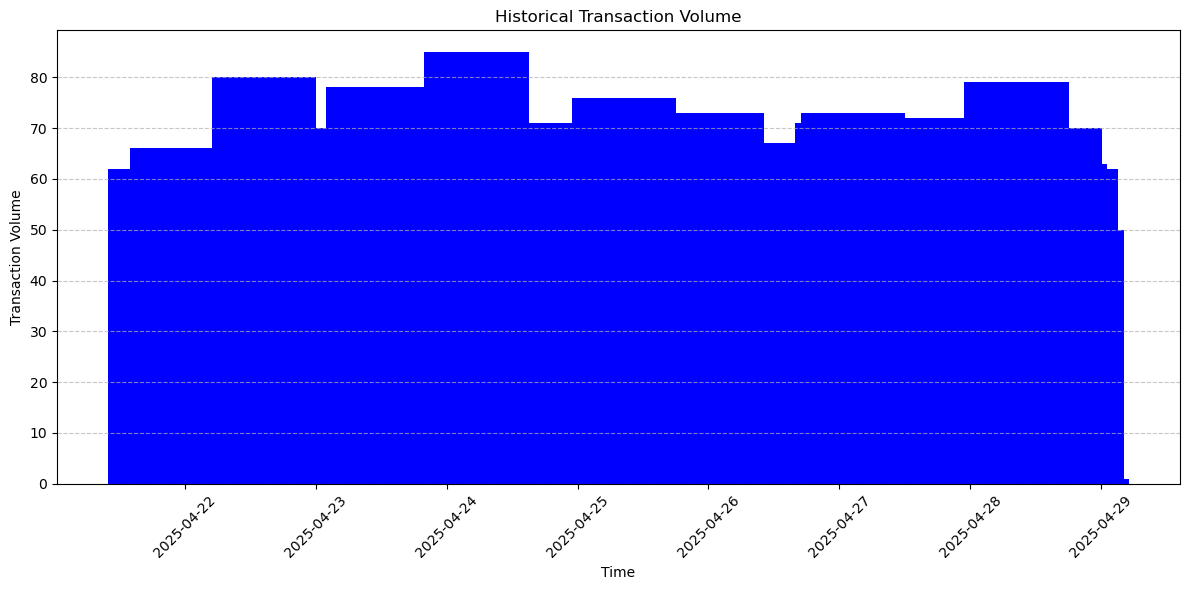

In [22]:
spark = SparkSession.builder.appName("TransactionVolume").getOrCreate()

df = spark.read.json('/home/amir/Desktop/Data-science-projects/CA2/transactions_data.json')
df = df.withColumn('timestamp', to_timestamp('timestamp'))


# grouping by hour:
df_grouped = df.groupBy(window('timestamp', '1 hour')).agg({'transaction_id': 'count'}).withColumnRenamed('count(transaction_id)', 'transaction_volume')


# Extract the start of the window as timestamp
df_grouped = df_grouped.withColumn('window_start', col('window')['start'])

# DataFrame to Pandas
df_pandas = df_grouped.select('window_start', 'transaction_volume').toPandas()

# Convert the window_start column to a numpy array of datetime objects
df_pandas['window_start'] = pd.to_datetime(df_pandas['window_start'])


plt.figure(figsize=(12, 6))
plt.bar(df_pandas['window_start'], df_pandas['transaction_volume'], color='b')
plt.title("Historical Transaction Volume")
plt.xlabel("Time")
plt.ylabel("Transaction Volume")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Real-time Transaction Volume

1. **Connect to Kafka**  

   A consumer (`transaction-group`) attaches to **darooghe.transactions** and starts reading from the first record.

2. **Listen for 30 s & count**  

   For every event it parses the ISO timestamp, rounds it down to the nearest minute, and increments a counter for that minute.  

   After the 30-second window it prints how many payments were captured.

3. **Visualise**  

   It sorts the minute-buckets chronologically and draws a blue bar-chart  

   *“Transaction Counts by Timestamp”* — one bar per minute, bar height = number of transactions seen during that minute.


Starting the real-time consumer...
Finished collecting data for 30 seconds.
Total transactions collected: 69088


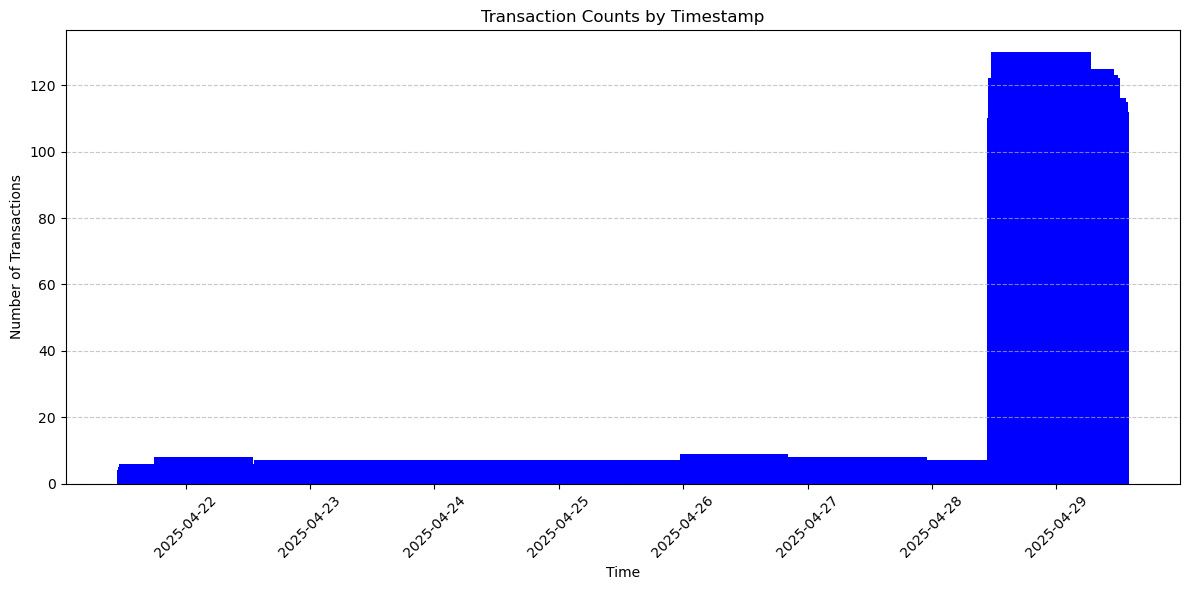

%6|1745901131.819|FAIL|rdkafka#consumer-12| [thrd:amir-Lenovo:9092/0]: amir-Lenovo:9092/0: Disconnected (after 183787ms in state UP)
%3|1745901131.820|FAIL|rdkafka#consumer-12| [thrd:amir-Lenovo:9092/0]: amir-Lenovo:9092/0: Connect to ipv4#127.0.1.1:9092 failed: Connection refused (after 0ms in state CONNECT)
%6|1745901131.877|FAIL|rdkafka#consumer-12| [thrd:GroupCoordinator]: GroupCoordinator: amir-Lenovo:9092: Disconnected (after 184000ms in state UP)
%3|1745901131.877|FAIL|rdkafka#consumer-12| [thrd:GroupCoordinator]: GroupCoordinator: amir-Lenovo:9092: Connect to ipv4#127.0.1.1:9092 failed: Connection refused (after 0ms in state CONNECT)
%3|1745901131.878|FAIL|rdkafka#consumer-12| [thrd:localhost:9092/bootstrap]: localhost:9092/bootstrap: Connect to ipv4#127.0.0.1:9092 failed: Connection refused (after 0ms in state CONNECT)
%3|1745901131.961|FAIL|rdkafka#consumer-12| [thrd:localhost:9092/bootstrap]: localhost:9092/bootstrap: Connect to ipv4#127.0.0.1:9092 failed: Connection refused

In [23]:
kafka_broker = 'localhost:9092'
topic = 'darooghe.transactions'

conf = {
    'bootstrap.servers': kafka_broker,
    'group.id': 'transaction-group',
    'auto.offset.reset': 'earliest',  # reading from the earliest message
}

consumer = Consumer(conf)
consumer.subscribe([topic])

# a counter to count transactions by timestamp
transaction_count_by_time = Counter()

collect_duration = 30  # Collect for 30 seconds

def collect_data_for_duration(duration=collect_duration):
    start_time = time.time()
    while time.time() - start_time < duration:
        msg = consumer.poll(timeout=5.0)
        
        if msg is None:
            continue
    
        
        transaction_event = json.loads(msg.value().decode('utf-8'))
        # Adjusted timestamp format
        event_time = datetime.strptime(transaction_event['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ")
        
        # Round the timestamp to the minute
        event_time_rounded = event_time.replace(second=0, microsecond=0)

        # Count the transaction for that timestamp
        transaction_count_by_time[event_time_rounded] += 1
        
    
    print(f"Finished collecting data for {duration} seconds.")
    print(f"Total transactions collected: {sum(transaction_count_by_time.values())}")

def plot_transaction_counts():
    # Sort the data by time
    sorted_times = sorted(transaction_count_by_time.keys())
    transaction_counts = [transaction_count_by_time[time] for time in sorted_times]
    

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_times, transaction_counts, color='b')
    plt.title("Transaction Counts by Timestamp")
    plt.xlabel("Time")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def consume_and_plot():

    collect_data_for_duration(collect_duration)
    plot_transaction_counts()

if __name__ == "__main__":
    print("Starting the real-time consumer...")
    consume_and_plot()


### Merchant Analysis

1. **Connect to Kafka**  

   A consumer (`merchant-transaction-group`) reads every message on  
   `darooghe.transactions`, starting from the very first record.

2. **Count for 30 seconds**  

   For each event we pull the `merchant_id` and increment a running
   counter.  

   When the 30-second timer ends the script prints how many payments it
   saw in total.

3. **Pick the winners & plot**  

   It sorts that counter, keeps the 5 busiest merchants, and draws a green
   bar-chart titled **“Top 5 Merchants by Transaction Counts”**.  

   Highest bar = most payments during the collection window.


Starting the real-time consumer...
Finished collecting data for 30 seconds.
Total transactions collected: 44256


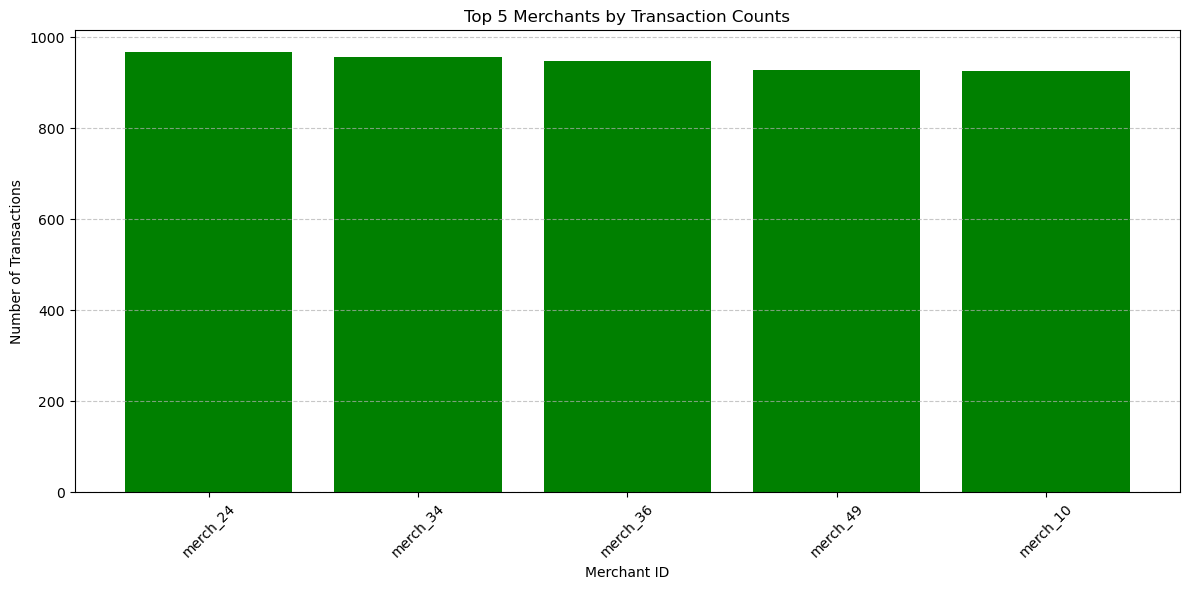

In [18]:
kafka_broker = 'localhost:9092' 
topic = 'darooghe.transactions'

conf = {
    'bootstrap.servers': kafka_broker,
    'group.id': 'merchant-transaction-group',
    'auto.offset.reset': 'earliest',  # reading from the earliest message
}


consumer = Consumer(conf)
consumer.subscribe([topic])

# a counter to count transactions by merchant_id
merchant_transaction_count = Counter()

collect_duration = 30  # Collect for 30 seconds

def collect_data_for_duration(duration=collect_duration):
    start_time = time.time()
    while time.time() - start_time < duration:
        msg = consumer.poll(timeout=5.0)
        
        if msg is None:
            continue
        
        # print("Message received:", msg.value())
        

        transaction_event = json.loads(msg.value().decode('utf-8'))
        # Get merchant_id and count the transaction
        merchant_id = transaction_event['merchant_id']
        merchant_transaction_count[merchant_id] += 1
        

    print(f"Finished collecting data for {duration} seconds.")
    print(f"Total transactions collected: {sum(merchant_transaction_count.values())}")

def plot_top_5_merchants():
    # Sort merchants by the number of transactionsr
    sorted_merchants = sorted(merchant_transaction_count.items(), key=lambda x: x[1], reverse=True)
    top_5_merchants = sorted_merchants[:5]
    
    # Unzip into merchant_id and transaction_count
    merchants, transaction_counts = zip(*top_5_merchants)
    

    plt.figure(figsize=(12, 6))
    plt.bar(merchants, transaction_counts, color='g')
    plt.title("Top 5 Merchants by Transaction Counts")
    plt.xlabel("Merchant ID")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def consume_and_plot():
    collect_data_for_duration(collect_duration)
    plot_top_5_merchants()

if __name__ == "__main__":
    print("Starting the real-time consumer...")
    consume_and_plot()


### User Activity

1. **Listen to Kafka for 30 sec**  

   A consumer (`group = "user-activity-group"`) reads every event from  
   `darooghe.transactions`, starting at the very first message.

2. **Count as we go**  

   Each time a record arrives we grab its `customer_id` and increment a
   simple Python `Counter`.  

   After the 30-second window the script prints how many transactions were
   seen in total.

3. **Show the results**  

   It sorts customers by transaction count and draws a red bar-chart  

   The x-axis lists customer IDs, the y-axis shows how many times each one
   paid during the collection window.



Starting the real-time consumer...
Finished collecting data for 30 seconds.
Total transactions collected: 44227


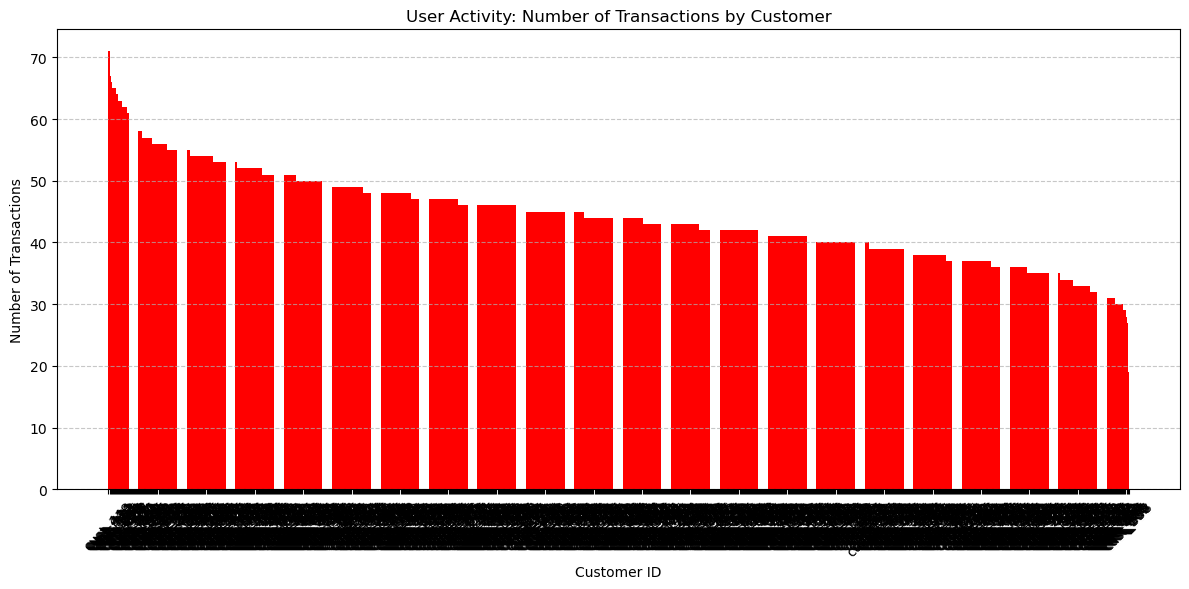

In [17]:
kafka_broker = 'localhost:9092'
topic = 'darooghe.transactions'

conf = {
    'bootstrap.servers': kafka_broker,
    'group.id': 'user-activity-group',
    'auto.offset.reset': 'earliest',  # reading from the earliest message
}

consumer = Consumer(conf)
consumer.subscribe([topic])

# a counter to count transactions by customer_id
user_transaction_count = Counter()

collect_duration = 30  # Collect for 30 seconds

def collect_data_for_duration(duration=collect_duration):
    start_time = time.time()
    while time.time() - start_time < duration:
        msg = consumer.poll(timeout=5.0)
        
        if msg is None:
            continue
        
        # print("Message received:", msg.value())
    
        transaction_event = json.loads(msg.value().decode('utf-8'))
        # Get customer_id and count the transaction
        customer_id = transaction_event['customer_id']
        user_transaction_count[customer_id] += 1
        
    
    print(f"Finished collecting data for {duration} seconds.")
    print(f"Total transactions collected: {sum(user_transaction_count.values())}")

def plot_user_activity():
    # Sort users by the num of transactions
    sorted_users = sorted(user_transaction_count.items(), key=lambda x: x[1], reverse=True)
    
    # Unzip into two customer_id and transaction_count
    users, transaction_counts = zip(*sorted_users)
    

    plt.figure(figsize=(12, 6))
    plt.bar(users, transaction_counts, color='r')
    plt.title("User Activity: Number of Transactions by Customer")
    plt.xlabel("Customer ID")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def consume_and_plot():
    collect_data_for_duration(collect_duration)
    plot_user_activity()

if __name__ == "__main__":
    print("Starting the real-time consumer...")
    consume_and_plot()


## Bonus Tasks


### Advanced Fraud Patterns

1. **Connect to Kafka**

   The script spins up a Kafka consumer (`darooghe.transactions`, group `fraud-patterns‐group`) and listens for ~45 seconds.

2. **Three live checks on every message**

   *a.  Activity histogram* — for each merchant-category it counts how many payments arrive in each hour of the day.  

   *b.  Outside-business-hours flag* — if a payment lands when the shop is “closed”, its `transaction_id` goes to `fraud_out_of_hours`.  

   *c.  Sudden spike detector* — keeps a rolling 5-minute window per merchant.  
     The rule is  

     $
        \text{current\_txn\_count} > \text{SPIKE\_FACTOR} \times \text{baseline\_avg}
     $

     where **baseline avg** is that merchant’s average transactions per hour
     over the last **1 hour**.  
     
     When the inequality is true the `(merchant, timestamp, burst-size)` is saved in `fraud_spikes`.

3. **After the listening window**  

   * Prints how many outside-hours transactions and spike events were flagged.  

   * Plots a 24-hour line-chart showing when each merchant-category is most active.  
   
   * Dumps a few example spike lines such as  
   
     `merch_17   2025-04-28 19:23:14  » 12 txns in ≤5 min`.

In short, this cell demonstrates live fraud heuristics (odd hours & bursts)
plus a simple visual of “what time of day each sector is busiest”.



Outside-hours transactions: 5577 flagged
Sudden spikes detected    : 0



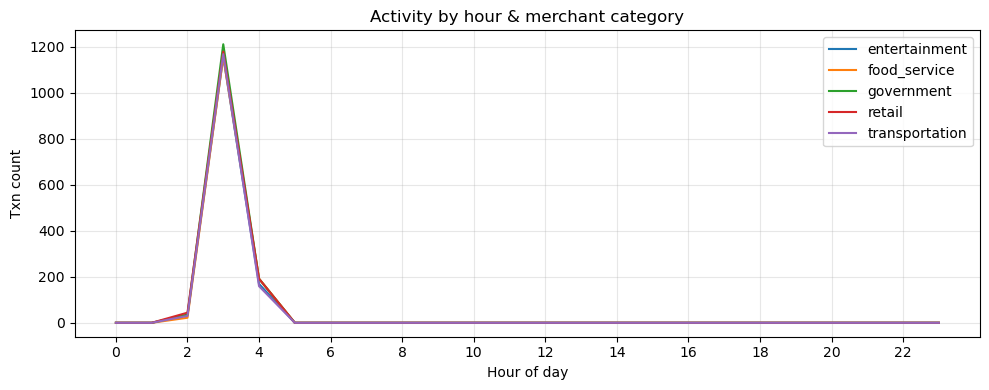

In [15]:
BROKER = "localhost:9092"
TOPIC  = "darooghe.transactions"
GROUP  = "fraud-patterns-group"

conf = {
    "bootstrap.servers": BROKER,
    "group.id": GROUP,
    "auto.offset.reset": "earliest"
}
consumer = Consumer(conf)
consumer.subscribe([TOPIC])

# default business hours by merchant_category
BUSINESS_HOURS = {
    "retail"        : (8, 22),
    "food_service"  : (7, 1),   
    "entertainment" : (10, 2),
    "transportation": (0, 24),
    "government"    : (8, 17)
}

SPIKE_WINDOW_MIN   = 5                # rolling window in minutes
SPIKE_FACTOR       = 3                # >SPIKE_FACTOR× baseline ⇒ spike
BASELINE_HORIZON_H = 1                # how many hours of history form “baseline”

merchant_hour_hist   = Counter()                    # (merch_cat, hour) → count
merchant_rolling     = defaultdict(deque)           # merch_id → deque[timestamps]
merchant_baseline    = Counter()                    # merch_id → hourly counts
fraud_out_of_hours   = []                           # list of flagged txn_ids
fraud_spikes         = []                           # list of (merchant_id, ts)

COLLECT_SEC = 45    # listen this long then summarise

start = time.time()
while time.time() - start < COLLECT_SEC:
    msg = consumer.poll(timeout=2.0)
    if msg is None or msg.error():
        continue

    try:
        tx = json.loads(msg.value().decode("utf-8"))
        ts  = datetime.strptime(tx["timestamp"], "%Y-%m-%dT%H:%M:%S.%fZ")
        mid = tx["merchant_id"]
        mcat= tx["merchant_category"]
        tid = tx["transaction_id"]
    except Exception as e:
        logging.warning("bad record: %s", e)
        continue

    hour = ts.hour
    # update part-of-day for “most active part of day”
    merchant_hour_hist[(mcat, hour)] += 1

    # outside-business-hours check 
    open_h, close_h = BUSINESS_HOURS.get(mcat, (8, 20))
    in_hours = (open_h <= hour < close_h) if open_h < close_h else (hour >= open_h or hour < close_h)
    if not in_hours:
        fraud_out_of_hours.append(tid)

    # spike detection per merchant - rolling window
    dq = merchant_rolling[mid]
    dq.append(ts)
    # drop events older than SPIKE_WINDOW
    while dq and (ts - dq[0]) > timedelta(minutes=SPIKE_WINDOW_MIN):
        dq.popleft()

    # update baseline counts (1-hour buckets)
    bucket_start = ts.replace(minute=0, second=0, microsecond=0)
    merchant_baseline[(mid, bucket_start)] += 1

    # compute baseline avg over last BASELINE_HORIZON_H hours
    past = [merchant_baseline[(mid, bucket_start - timedelta(hours=h))]
            for h in range(BASELINE_HORIZON_H+1)]
    baseline = (sum(past) / max(1, len(past)))
    if baseline > 0 and len(dq) > SPIKE_FACTOR * baseline:
        fraud_spikes.append((mid, ts, len(dq)))

consumer.close()

print(f"\nOutside-hours transactions: {len(fraud_out_of_hours)} flagged")
print(f"Sudden spikes detected    : {len(fraud_spikes)}\n")

# show Most-active part of day per merchant_category
fig, ax = plt.subplots(figsize=(10,4))
for mcat in sorted({k[0] for k in merchant_hour_hist}):
    hours = list(range(24))
    counts = [merchant_hour_hist[(mcat,h)] for h in hours]
    ax.plot(hours, counts, label=mcat)
ax.set_xticks(range(0,24,2)); ax.set_xlabel("Hour of day")
ax.set_ylabel("Txn count"); ax.set_title("Activity by hour & merchant category")
ax.legend(); ax.grid(alpha=.3); plt.tight_layout(); plt.show()

# see some sample spikes
if fraud_spikes:
    print("Sample spikes:")
    for mid, ts, n in fraud_spikes[:10]:
        print(f"  {mid:8}  {ts}  » {n} txns in ≤{SPIKE_WINDOW_MIN} min")



### Commission Audit System

1. **Load & prep**  

   Spark opens, reads the transaction JSON, and gives us a DataFrame to work on.

2. **Pick a better fee type**  

   A tiny rule-engine tags every row with the *recommended* commission model.

3. **Compute the “what-if” fee**

$
\text{new\_fee} =
\begin{cases}
20{,}000 & \text{(flat)}\\[6pt]
0.02 \times \text{amount} & \text{(progressive)}\\[6pt]
\begin{cases}
0.015\,a & a \le 1{,}000{,}000\\
0.015\!\times\!10^{6} + 0.01\,(a-10^{6}) & a > 1{,}000{,}000
\end{cases} & \text{(tiered)}
\end{cases}
$

&nbsp;where \(a\) is the transaction amount (IRR).

4. **Compare & print**  

   Spark aggregates the simulated total vs. the real total and prints something like:

In [11]:
spark = SparkSession.builder.appName("CommissionAudit").getOrCreate()

# Load historical transactions 
df = spark.read.json("/home/amir/Desktop/Data-science-projects/CA2/transactions_data.json")

# UDF commission type
def recommend_commission(amount, merchant_category, customer_type):
    if customer_type == "CIP":
        return "flat"
    if merchant_category == "government" and amount > 1_000_000:
        return "tiered"
    if amount < 300_000:
        return "flat"
    elif amount < 1_500_000:
        return "progressive"
    else:
        return "tiered"

rec_udf = udf(recommend_commission, StringType())

df = df.withColumn(
        "recommended_type",
        rec_udf(col("amount"), col("merchant_category"), col("customer_type"))
     )

FLAT_FEE        = 20_000                # IRR
PROG_RATE       = 0.020                 # 2 %
TIER_RATE_LOW   = 0.015                 # up to 1 M
TIER_RATE_HIGH  = 0.010                 # above 1 M

def simulate_fee(amount, ctype):
    if ctype == "flat":
        return float(FLAT_FEE)
    if ctype == "progressive":
        return float(amount * PROG_RATE)
    
    if amount <= 1_000_000:
        return float(amount * TIER_RATE_LOW)
    return float(1_000_000 * TIER_RATE_LOW + (amount - 1_000_000) * TIER_RATE_HIGH)

sim_udf = udf(simulate_fee, DoubleType())

df = (df
      .withColumn("sim_fee", sim_udf(col("amount"), col("recommended_type")))
      .withColumn("fee_gain", col("sim_fee") - col("commission_amount"))
)

# Aggregated validation report
summary = (df.groupBy("recommended_type")
             .agg({"fee_gain":"avg",
                    "sim_fee":"sum",
                    "commission_amount":"sum"})
             .withColumnRenamed("avg(fee_gain)", "avg_gain")
             .withColumnRenamed("sum(sim_fee)", "total_simulated")
             .withColumnRenamed("sum(commission_amount)", "total_actual")
)
summary.show(truncate=False)

# calculate Overall improvement
totals = summary.agg({"total_simulated":"sum",
                      "total_actual":"sum"}).collect()[0]
improvement_pct = (totals["sum(total_simulated)"] - totals["sum(total_actual)"]) \
                  / totals["sum(total_actual)"] * 100
print(f"\nOverall commission improvement if recommendations applied: "
      f"{improvement_pct:.2f}%")


+----------------+------------+-------------------+-------------------+
|recommended_type|total_actual|total_simulated    |avg_gain           |
+----------------+------------+-------------------+-------------------+
|flat            |72286729    |8.42E7             |2829.7555819477434 |
|progressive     |65289712    |6.529154530000002E7|0.49031826691665803|
|tiered          |68459458    |4.448523260999999E7|-11689.04212091663 |
+----------------+------------+-------------------+-------------------+


Overall commission improvement if recommendations applied: -5.85%


### Pipeline Optimization

#### Monitoring the **Kafka consumer lag** & **GC-time** of our pipeline

Keeping an eye on just **two tiny metrics** tells us whether the streaming part of the
project is healthy:

| Metric | Why it matters | Where it lives |
|--------|---------------|----------------|
| **`darooghe_consumer_lag`** | *“How many messages is my consumer behind the head of* `darooghe.transactions` *?”*  <br>When the value grows, dashboards and fraud–detection fall out of “real-time”. | Our **Python exporter** on **`:8000/metrics`** |
| **`go_gc_duration_seconds`** (and its `_sum`, `_count` children) | Wall-clock time the Go runtime spends inside **kafka_exporter**’s garbage-collector.  <br>Spikes tell us the exporter itself is struggling to keep up. | The **Go `kafka_exporter`** on **`:9308/metrics`** |

Everything below is copy-paste friendly and takes ≈ 2 minutes.

---

#### 1 Run the two exporters

```bash
# 1-A: Kafka-side metrics (in Go)
./kafka_exporter \
  --kafka.server=localhost:9092 \
  --web.listen-address=:9308

# 1-B: Custom consumer-lag gauge (Python)
run bellow cell
# → prints: Prometheus endpoint → http://localhost:8000/metrics


In [14]:
BROKER   = "localhost:9092"
TOPIC    = "darooghe.transactions"
GROUP_ID = "darooghe-consumer"
PORT     = 8000                   

lag = Gauge("darooghe_consumer_lag",
            "Current Kafka consumer lag",
            ["partition"])

conf = {
    "bootstrap.servers": BROKER,
    "group.id": GROUP_ID,
    "auto.offset.reset": "earliest",
    "enable.auto.commit": False
}
c = Consumer(conf)
c.subscribe([TOPIC])

start_http_server(PORT)
print(f"Prometheus endpoint → http://localhost:{PORT}/metrics")

def bye(*_):
    c.close(); sys.exit(0)
signal.signal(signal.SIGINT, bye); signal.signal(signal.SIGTERM, bye)

while True:
    msg = c.poll(1.0)
    # update lag even if no new msg
    for tp in c.assignment():
        low, high = c.get_watermark_offsets(tp, cached=False)
        pos = c.position([tp])[0].offset
        lag.labels(partition=str(tp.partition)).set(high - pos)
    # process the message itself
    if msg and not msg.error():
        _ = json.loads(msg.value().decode("utf-8"))
    time.sleep(0.5)


Prometheus endpoint → http://localhost:8000/metrics


SystemExit: 0

/home/amir/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
